# Imports

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm as progress 
from tensorflow.keras import Model
from tensorflow.data import Dataset 
from tensorflow.keras.optimizers import Adam
from pandas import read_csv, DataFrame, concat
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Embedding, Dropout, Flatten, Dense
from tensorflow import convert_to_tensor, GradientTape, device, DeviceSpec
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Constant Variables
batch_size = 4096

# Loading SMS Data

In [2]:
df = read_csv("../../data/sms.csv")
df = df.drop(columns=["Unnamed: 0"])
df.sample(5)

,text,type
2320,"[152, 452, 10, 463, 4025, 194, 17, 0, 0, 0, 0,...",0
3605,"[554, 50, 5090, 15, 17, 220, 17, 17, 17, 0, 0,...",0
4306,"[611, 5534, 133, 57, 3, 507, 984, 17, 0, 0, 0,...",0
3340,"[98, 459, 244, 17, 17, 17, 0, 0, 0, 0, 0, 0, 0...",0
2164,"[600, 261, 15, 218, 295, 3106, 10, 2735, 0, 0,...",0


# Preparing SMS Data


In [3]:
# Load & Prepare Data
df["text"] = df["text"].apply(lambda sms: [int(word) for word in sms[1:-1].split(", ")])
df["type"] = df["type"].apply(lambda label: int(label))

# # Train / Valid / Test Split
x_train, x_test, y_train, y_test = train_test_split(df["text"], df["type"], test_size=0.30, stratify=df["type"], random_state=2022)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.50, stratify=y_test, random_state=2022)

# Train / Test / Valid Dataset
train_dataset = Dataset.from_tensor_slices((convert_to_tensor(x_train.to_list()), convert_to_tensor(y_train.to_list()))).batch(batch_size=batch_size)
valid_dataset = Dataset.from_tensor_slices((convert_to_tensor(x_valid.to_list()), convert_to_tensor(y_valid.to_list()))).batch(batch_size=batch_size)
test_dataset = Dataset.from_tensor_slices((convert_to_tensor(x_test.to_list()), convert_to_tensor(y_test.to_list()))).batch(batch_size=batch_size)

# Model

In [4]:
class SMSClassifier(Model):
    def __init__(self, path):
        super(SMSClassifier, self).__init__()
        self.path = path
        self.embedding = Embedding(6260, 8)
        self.dropout = Dropout(0.5)
        self.flatten = Flatten()
        self.fc1 = Dense(1200, activation="relu")
        self.fc2 = Dense(600, activation="relu")
        self.fc3 = Dense(1, activation="sigmoid")

    def call(self, sentence):
        sentence = self.embedding(sentence)
        sentence = self.dropout(sentence)
        sentence = self.flatten(sentence)
        sentence = self.fc1(sentence)
        sentence = self.fc2(sentence)
        sentence = self.fc3(sentence)
        return sentence

    def fit(self, datasets, epochs, optimizer, loss_fn, train_loss=[1], valid_loss=[1], best_epoch=0):
        with device(DeviceSpec(device_type="GPU", device_index=0)):
            for epoch in (tracker := progress(range(epochs))):
                tracker.set_description(f"Epoch #{epoch+1}")
                # Train Step
                train_loss.append(self.train_step(datasets[0], optimizer, loss_fn))
                # Eval Step
                valid_loss.append(self.eval_step(datasets[1], loss_fn))
                # Saving Model If Performance Improves
                if valid_loss[-1] <= min(valid_loss):
                    best_epoch = epoch
                    self.save(self.path)
                # Updating the tracker
                if epoch == epochs-1:
                    tracker.set_description(f"Best Epoch #{best_epoch+1}")
                    tracker.set_postfix_str(f"Training Loss = {train_loss[best_epoch]}, Validiation Loss = {valid_loss[best_epoch]}")
                else:
                    tracker.set_postfix_str(f"Training Loss = {train_loss[-1]}, Validiation Loss = {valid_loss[-1]}")
                    
        # Plotting Results
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4), dpi=250)
        ax.set_title("Training Loss (Green) vs Validation Loss (Blue)")
        ax.plot(train_loss, "g")
        ax.plot(valid_loss, "b")
        ax.set_xlim((0, len(train_loss)-1))
        ax.set_ylim((0, max(max(train_loss), max(valid_loss))))
        plt.show()
        
    def train_step(self, dataset, optimizer, loss_fn):
        for step, batch in enumerate(dataset):
            with GradientTape() as tape:
                y_pred = self(batch[0], training=True)
                loss = loss_fn(batch[1], y_pred)
            grads = tape.gradient(loss, self.trainable_weights)
            optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return loss.numpy()
    
    def eval_step(self, dataset, loss_fn):
        for step, batch in enumerate(dataset):
            y_pred = self(batch[0], training=False)
            loss = loss_fn(batch[1], y_pred)
        return loss.numpy()
    
    def evaluate(self, dataset, y_pred=[], y_true=[]):
        self.load(self.path)
        for step, batch in enumerate(dataset):
            y_pred.extend([int(prediction[0] > 0.5) for prediction in (self(batch[0], training=False).numpy())])
            y_true.extend(batch[1])
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        rc1, rc2, rc3 = precision_recall_curve(y_true, y_pred)
        pr_auc = auc(rc2,  rc1)
        print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nPR_AUC: {pr_auc}")
        ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=[0, 1]).plot()
        plt.show()
        return accuracy, precision, recall, pr_auc
    
    def saveResults(self, lib, nam, typ, acc, pre, rec, pr):
        df = read_csv("../../data/results.csv")
        df2 = DataFrame([[lib, nam, typ, acc, pre, rec, pr]], 
                        columns=["Library", "Model", "Type", "Accuracy", "Precision", "Recall", "PR_AUC"])
        df = concat([df2, df])
        if "Unnamed: 0" in df:
            df = df.drop(columns=["Unnamed: 0"])
        df.to_csv("../../data/results.csv")

    def save(self, path):
        self.save_weights(path)

    def load(self, path, input_shape=(batch_size, 300)):
        self.build(input_shape)
        self.load_weights(path)

    def print(self, input_shape=(batch_size, 300)):
        self.build(input_shape)
        self.summary()

# Model Summary

In [5]:
model = SMSClassifier("../../models/nn.h5")
model.print()

Model: "sms_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1426784   
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  2881200   
                                                                 
 dense_1 (Dense)             multiple                  720600    
                                                                 
 dense_2 (Dense)             multiple                  601       
                                                                 
Total params: 5,029,185
Trainable params: 5,029,185


# Model Training

Best Epoch #288: 100%|██████████| 300/300 [01:25<00:00,  3.52it/s, Training Loss = 0.012972712516784668, Validiation Loss = 0.05122087150812149]


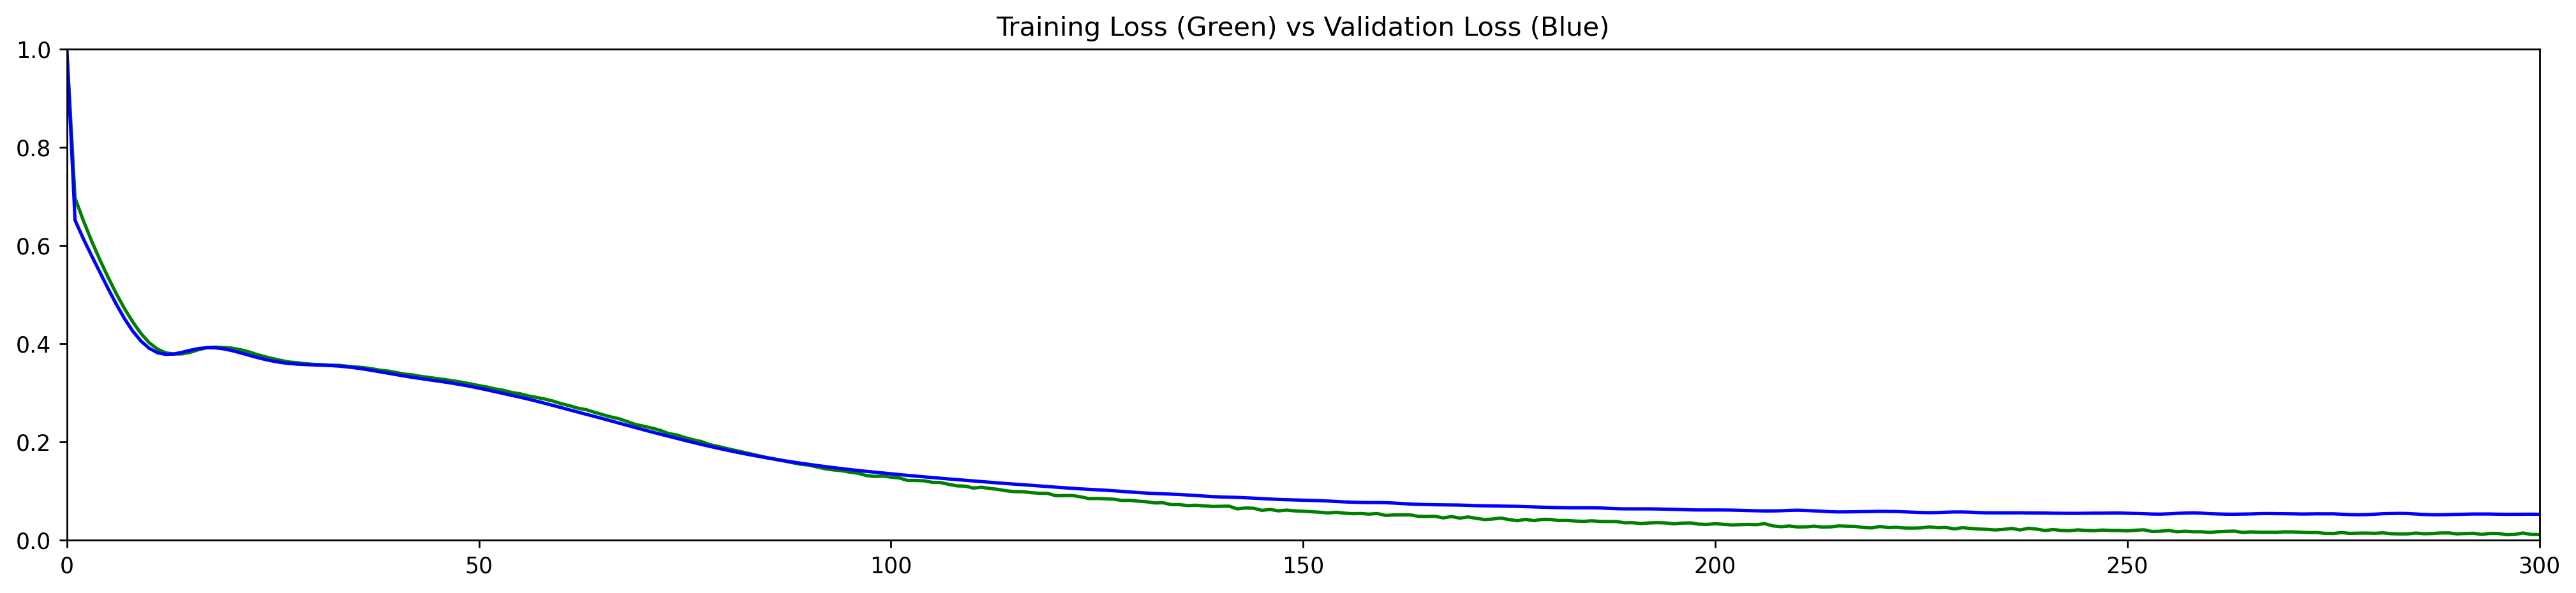

In [6]:
model.fit([train_dataset, valid_dataset], 300, Adam(learning_rate=1e-4), BinaryCrossentropy())

# Model Evaluation

Train Results
Accuracy: 0.9971794871794872
Precision: 0.9942084942084942
Recall: 0.9847036328871893
PR_AUC: 0.9904817045734827


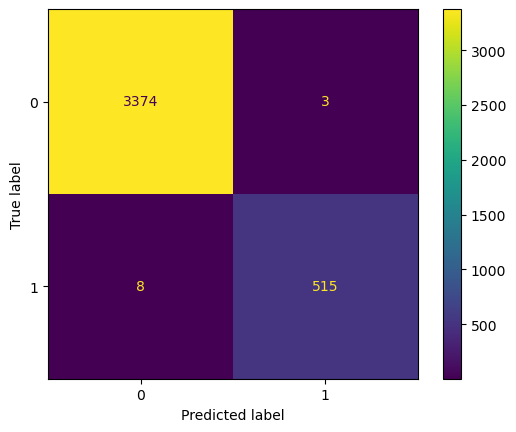

In [7]:
print("Train Results")
acc, pre, re, pr = model.evaluate(train_dataset)
model.saveResults("tensorflow", "nn", "train", acc, pre, re, pr)

Valid Results
Accuracy: 0.9955658783783784
Precision: 0.9951612903225806
Recall: 0.9716535433070866
PR_AUC: 0.9853077546526714


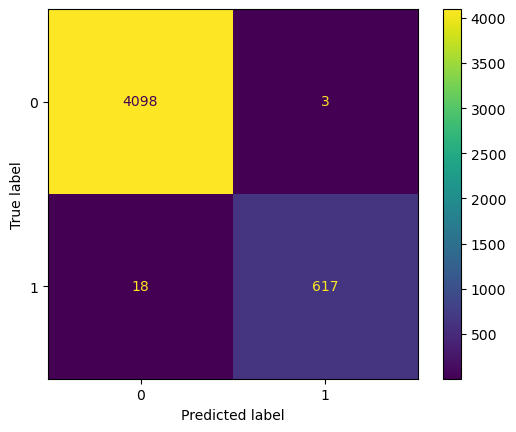

In [8]:
print("Valid Results")
acc, pre, re, pr = model.evaluate(valid_dataset)
model.saveResults("tensorflow", "nn", "valid", acc, pre, re, pr)

Test Results
Accuracy: 0.9951543431442929
Precision: 0.9958677685950413
Recall: 0.9678714859437751
PR_AUC: 0.9840232525386114


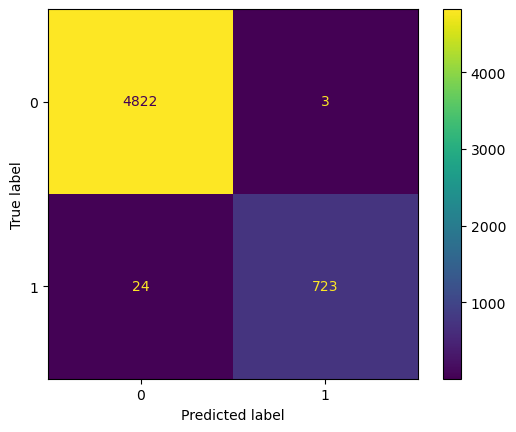

In [9]:
print("Test Results")
acc, pre, re, pr = model.evaluate(test_dataset)
model.saveResults("tensorflow", "nn", "test", acc, pre, re, pr)